In [1]:
!pip install pyspark

# Import necessary libraries
from pyspark.sql import SparkSession
from pyspark.sql.window import Window  # Import for Window functions
from pyspark.sql.functions import (avg, sum as _sum, col, regexp_replace, 
                            count, when, isnan, rlike, corr, lag, round, row_number)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.3/317.3 MB 4.4 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.2-py2.py3-none-any.whl size=317812366 sha256=840852d90289b7e0cfcb9c5bbe710dae2a41b148efc59723fbd93969cbe4a1db
  Stored in directory: /root/.cache/pip/wheels/34/34/bd/03944534c44b677cd5859f248090daa9fb27b3c8f8e5f49574
Successfully built pyspark


In [2]:
# Step 1: Data Analysis

# Initialize Spark session
spark = SparkSession.builder.appName("AirlineMarketAnalysis").getOrCreate()

# Load the dataset
file_path = "/kaggle/input/us-airline-industry-dataset-1993-2024"
df = spark.read.csv(file_path, header=True, inferSchema=True)

# Display the dataset schema to understand its structure
df.printSchema()

# Make 'Year' and 'quarter' columns are properly formatted as integers
df = df.withColumn("Year", regexp_replace("Year", "[^0-9]", "").cast("int"))
df = df.withColumn("quarter", regexp_replace("quarter", "[^0-9]", "").cast("int"))

# Filter out rows with year values outside a reasonable range (1900-2024) // Found some corrupt dates
df = df.filter((col("Year") >= 1900) & (col("Year") <= 2024))

# Confirm that the filtering and formatting were successful
df.select("Year", "quarter").distinct().show()

# Display the first few rows of the cleaned dataset to understand its structure
df.show(5)

# Generate summary statistics for the dataset
df.describe().show()

# Analyze fare trends over time by airline
fare_trends = df.groupBy("Year", "carrier_lg").agg(avg("fare").alias("Average_Fare")).orderBy("Year", "carrier_lg")
fare_trends.show()

# Examine seasonal trends in passenger demand
seasonal_demand = df.groupBy("Year", "quarter").agg(_sum("passengers").alias("Total_Passengers")).orderBy("Year", "quarter")
seasonal_demand.show()

# Determine market share by airline based on passenger counts
market_share = df.groupBy("carrier_lg").agg(_sum("passengers").alias("Total_Passengers")).orderBy("Total_Passengers", ascending=False)
market_share.show()

# Assess the correlation between fare prices and passenger numbers
fare_passenger_corr = df.stat.corr("fare", "passengers")
print(f"Fare-Passenger Correlation: {fare_passenger_corr}")

# Assess the correlation between flight delays and passenger numbers
delay_passenger_corr = df.stat.corr("lf_ms", "passengers")
print(f"Delay-Passenger Correlation: {delay_passenger_corr}")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/08/15 14:30:11 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


root
 |-- tbl: string (nullable = true)
 |-- Year: string (nullable = true)
 |-- quarter: string (nullable = true)
 |-- citymarketid_1: integer (nullable = true)
 |-- citymarketid_2: integer (nullable = true)
 |-- city1: string (nullable = true)
 |-- city2: string (nullable = true)
 |-- airportid_1: integer (nullable = true)
 |-- airportid_2: integer (nullable = true)
 |-- airport_1: string (nullable = true)
 |-- airport_2: string (nullable = true)
 |-- nsmiles: integer (nullable = true)
 |-- passengers: integer (nullable = true)
 |-- fare: double (nullable = true)
 |-- carrier_lg: string (nullable = true)
 |-- large_ms: double (nullable = true)
 |-- fare_lg: double (nullable = true)
 |-- carrier_low: string (nullable = true)
 |-- lf_ms: double (nullable = true)
 |-- fare_low: double (nullable = true)
 |-- Geocoded_City1: string (nullable = true)
 |-- Geocoded_City2: string (nullable = true)
 |-- tbl1apk: string (nullable = true)



+----+-------+
|Year|quarter|
+----+-------+
|1998|      2|
|2001|      1|
|1998|      1|
|2002|      3|
|2014|      4|
|2000|      4|
|2003|      2|
|2013|      2|
|2012|      4|
|2007|      1|
|1999|      2|
|2003|      3|
|1997|      3|
|1999|      4|
|2009|      3|
|2000|      3|
|1996|      2|
|2022|      2|
|2008|      1|
|2009|      1|
+----+-------+
only showing top 20 rows

+-------+----+-------+--------------+--------------+--------------------+--------------------+-----------+-----------+---------+---------+-------+----------+------+----------+--------+-------+-----------+------+--------+--------------+--------------+--------------------+
|    tbl|Year|quarter|citymarketid_1|citymarketid_2|               city1|               city2|airportid_1|airportid_2|airport_1|airport_2|nsmiles|passengers|  fare|carrier_lg|large_ms|fare_lg|carrier_low| lf_ms|fare_low|Geocoded_City1|Geocoded_City2|             tbl1apk|
+-------+----+-------+--------------+--------------+------------------

24/08/15 14:30:29 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+--------+------------------+------------------+------------------+------------------+--------------------+--------------------+------------------+------------------+---------+---------+-----------------+------------------+------------------+----------+-------------------+------------------+-----------+-------------------+-----------------+--------------------+--------------------+--------------------+
|summary|     tbl|              Year|           quarter|    citymarketid_1|    citymarketid_2|               city1|               city2|       airportid_1|       airportid_2|airport_1|airport_2|          nsmiles|        passengers|              fare|carrier_lg|           large_ms|           fare_lg|carrier_low|              lf_ms|         fare_low|      Geocoded_City1|      Geocoded_City2|             tbl1apk|
+-------+--------+------------------+------------------+------------------+------------------+--------------------+--------------------+------------------+-----------------

+----+----------+------------------+
|Year|carrier_lg|      Average_Fare|
+----+----------+------------------+
|1993|      NULL|429.90616438356165|
|1993|        5J|           103.245|
|1993|        AA|251.38615128449092|
|1993|        AS| 147.6528846153846|
|1993|        BF|158.40285714285716|
|1993|        CO|196.81077922077924|
|1993|        DH|             195.5|
|1993|        DL| 224.9746359676415|
|1993|        FF|            141.25|
|1993|        HP|181.06295681063122|
|1993|        KP|            118.41|
|1993|        KW|           137.649|
|1993|        NK|63.618571428571435|
|1993|        NW| 213.0542307692307|
|1993|        OE|         143.51875|
|1993|        QQ|             89.22|
|1993|        RL|            123.46|
|1993|        TB|105.83833333333332|
|1993|        TW|179.14644699140405|
|1993|        TZ|121.64978260869565|
+----+----------+------------------+
only showing top 20 rows



+----+-------+----------------+
|Year|quarter|Total_Passengers|
+----+-------+----------------+
|1993|      1|          345741|
|1993|      2|          403857|
|1993|      3|          393045|
|1993|      4|          395495|
|1994|      1|          397667|
|1996|      1|          455842|
|1996|      2|          528950|
|1996|      3|          513137|
|1996|      4|          504663|
|1997|      1|          498839|
|1997|      2|          558781|
|1997|      3|          543861|
|1997|      4|          541227|
|1998|      1|          490013|
|1998|      2|          576258|
|1998|      3|          550397|
|1998|      4|          560083|
|1999|      1|          535092|
|1999|      2|          601315|
|1999|      3|          591353|
+----+-------+----------------+
only showing top 20 rows



+----------+----------------+
|carrier_lg|Total_Passengers|
+----------+----------------+
|        WN|        18470937|
|        AA|        12851640|
|        UA|        11204565|
|        DL|        10250494|
|        CO|         4070035|
|        B6|         4050943|
|        US|         3986823|
|        AS|         2489260|
|        NW|         2028363|
|        FL|          630241|
|        HP|          583510|
|        NK|          538210|
|        TZ|          473994|
|        F9|          379535|
|        VX|          350257|
|        TW|          298023|
|        YX|          288800|
|        G4|          239197|
|        QQ|           73957|
|        JI|           67010|
+----------+----------------+
only showing top 20 rows



Fare-Passenger Correlation: -0.17146027448639625


Delay-Passenger Correlation: -0.11697805504023849


In [3]:
# Step 2: Data Cleaning

# Print the initial number of rows before any cleaning
initial_total_row_count = df.count()
print(f"Number of rows before cleaning: {initial_total_row_count}")

# Identify and display any missing values across all columns
missing_values = df.select([count(when(col(c).isNull() | isnan(c), c)).alias(c) for c in df.columns])
missing_values.show()

# Address missing data by imputing median fare values where necessary
median_fare = df.approxQuantile("fare", [0.5], 0.0)[0]
df_cleaned = df.na.fill({"fare": median_fare})

# Remove duplicates
df_cleaned = df_cleaned.dropDuplicates()

# Manage outliers by capping fare values at the 99th percentile
fare_cap = df_cleaned.approxQuantile("fare", [0.99], 0.0)[0]
df_cleaned = df_cleaned.withColumn("fare", when(col("fare") > fare_cap, fare_cap).otherwise(col("fare")))

# Validate and enforce consistent year formatting across the dataset
df_cleaned = df_cleaned.withColumn("Year", col("Year").cast("int"))

# Filter to keep only the top 10 carriers by total passengers
top_10_carriers_df = df_cleaned.groupBy("carrier_lg") \
    .agg(_sum("passengers").alias("TotalPassengers")) \
    .orderBy(col("TotalPassengers").desc()) \
    .limit(10)

# Filter the cleaned DataFrame to include only these top 10 carriers
df_cleaned = df_cleaned.join(top_10_carriers_df.select("carrier_lg"), "carrier_lg")

# Verify dataset shape after cleaning and filtering
print(f"Number of rows after cleaning and filtering: {df_cleaned.count()}")



Number of rows before cleaning: 245955


+---+----+-------+--------------+--------------+-----+-----+-----------+-----------+---------+---------+-------+----------+----+----------+--------+-------+-----------+-----+--------+--------------+--------------+-------+
|tbl|Year|quarter|citymarketid_1|citymarketid_2|city1|city2|airportid_1|airportid_2|airport_1|airport_2|nsmiles|passengers|fare|carrier_lg|large_ms|fare_lg|carrier_low|lf_ms|fare_low|Geocoded_City1|Geocoded_City2|tbl1apk|
+---+----+-------+--------------+--------------+-----+-----+-----------+-----------+---------+---------+-------+----------+----+----------+--------+-------+-----------+-----+--------+--------------+--------------+-------+
|  0|   0|      0|             0|             0|    0|    0|          0|          0|        0|        0|      0|         0|   0|      1540|    1540|   1540|       1612| 1612|    1612|         39206|        240103| 200897|
+---+----+-------+--------------+--------------+-----+-----+-----------+-----------+---------+---------+-------+

Number of rows after cleaning and filtering: 229518


In [4]:
# Step 3.1: Create the 'Season' column and aggregate the data
# Define seasons based on quarters and calculate aggregate statistics for each carrier per year and quarter
df_cleaned = df_cleaned.withColumn("Season", when(col("quarter").isin([2, 3]), "Peak").otherwise("Off-Peak"))

aggregated_df = df_cleaned.groupBy("Year", "quarter", "carrier_lg", "Season") \
    .agg(
        avg("fare").alias("Avg_Fare"),
        _sum("passengers").alias("Total_Passengers"),
        avg("lf_ms").alias("Avg_Delay")
    ) \
    .orderBy("Year", "quarter", "carrier_lg")

# Step 3.2: Round Avg_Fare and Avg_Delay to 2 decimal places
aggregated_df = aggregated_df.withColumn("Avg_Fare", round(col("Avg_Fare"), 2))
aggregated_df = aggregated_df.withColumn("Avg_Delay", round(col("Avg_Delay"), 2))

# Step 3.3: Calculate Year-over-Year Fare Change and Passenger Growth
windowSpec = Window.partitionBy("carrier_lg").orderBy("Year", "quarter")
aggregated_df = aggregated_df.withColumn("YoY_Fare_Change", round(col("Avg_Fare") - lag(col("Avg_Fare"), 1).over(windowSpec), 2))
aggregated_df = aggregated_df.withColumn("YoY_Passenger_Growth", round(col("Total_Passengers") - lag(col("Total_Passengers"), 1).over(windowSpec), 2))

# Display the result: first 10 rows of the aggregated data, including calculated year-over-year changes
aggregated_df.select("Year", "quarter", "carrier_lg", "Avg_Fare", "YoY_Fare_Change", "YoY_Passenger_Growth", "Season", "Avg_Delay") \
    .orderBy("Year", "quarter", "carrier_lg") \
    .show(10, truncate=False)


+----+-------+----------+--------+---------------+--------------------+--------+---------+
|Year|quarter|carrier_lg|Avg_Fare|YoY_Fare_Change|YoY_Passenger_Growth|Season  |Avg_Delay|
+----+-------+----------+--------+---------------+--------------------+--------+---------+
|1993|1      |AA        |274.4   |NULL           |NULL                |Off-Peak|0.39     |
|1993|1      |AS        |207.79  |NULL           |NULL                |Off-Peak|0.53     |
|1993|1      |CO        |218.6   |NULL           |NULL                |Off-Peak|0.59     |
|1993|1      |DL        |248.57  |NULL           |NULL                |Off-Peak|0.4      |
|1993|1      |NW        |228.3   |NULL           |NULL                |Off-Peak|0.31     |
|1993|1      |UA        |271.99  |NULL           |NULL                |Off-Peak|0.32     |
|1993|1      |US        |219.52  |NULL           |NULL                |Off-Peak|0.38     |
|1993|1      |WN        |130.74  |NULL           |NULL                |Off-Peak|0.77     |

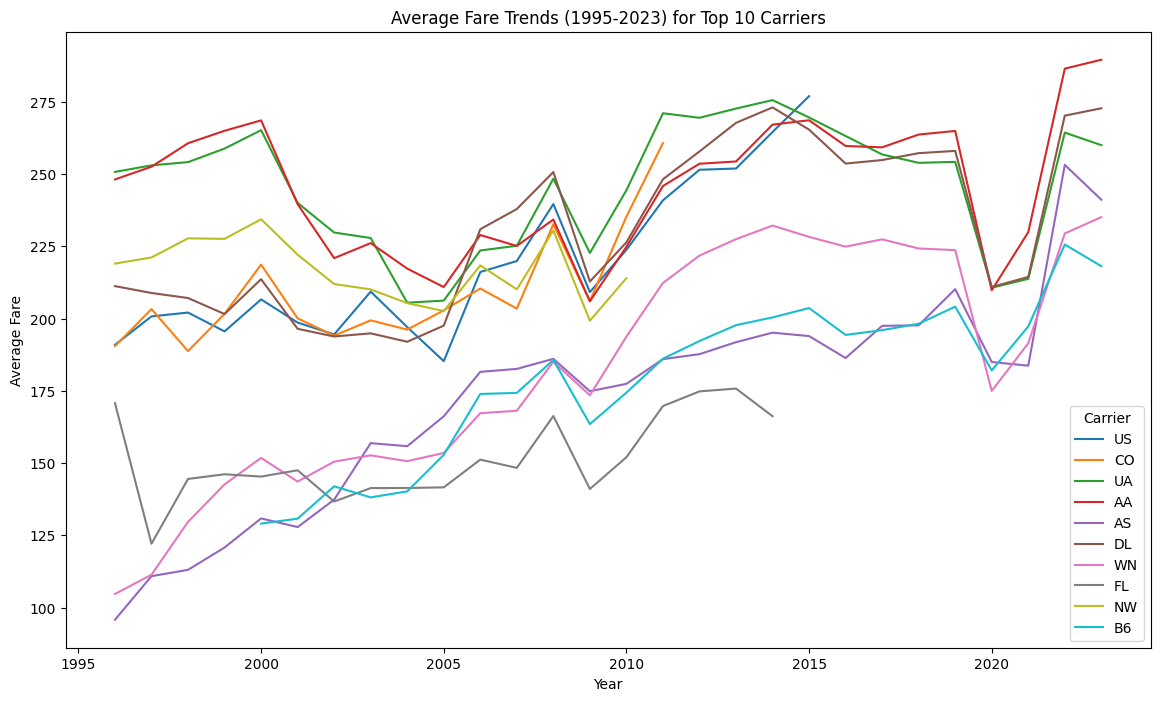

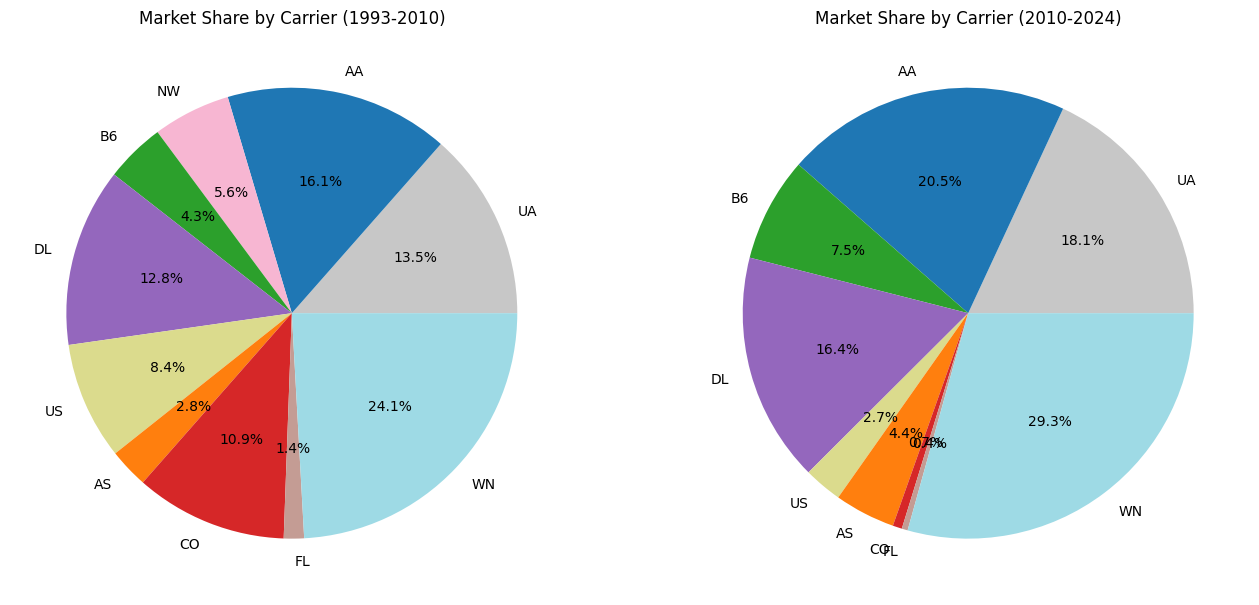

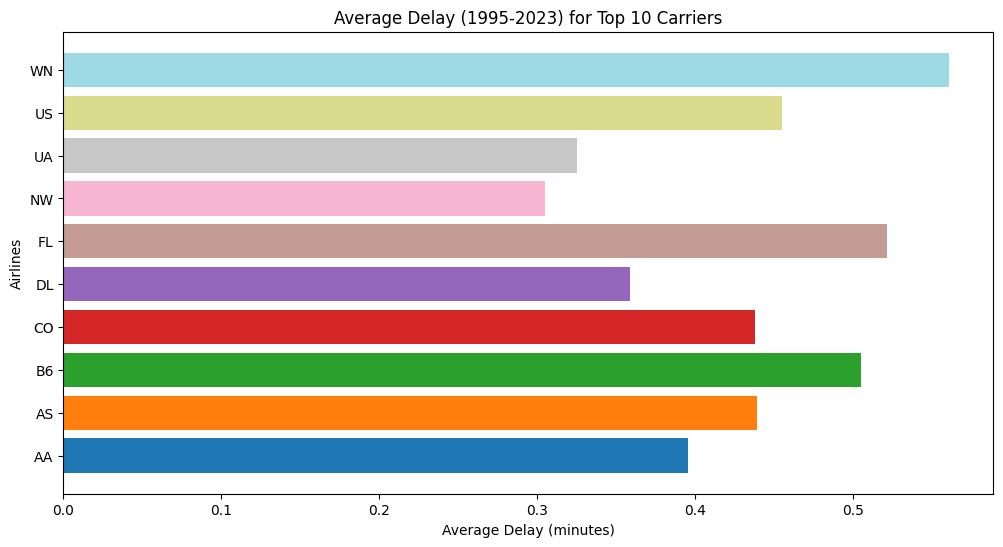

In [5]:
# Step 4: Visual Data Exploration and Analysis

# Step 4.1: Filter Data for the Analysis Period
top_flights_filtered_df = aggregated_df.filter((col("Year") >= 1995) & (col("Year") <= 2023))

# Step 4.2: Visualize Fare Trends Over Time for Top 10 Carriers
fare_trends_df = top_flights_filtered_df.groupBy("carrier_lg", "Year") \
    .agg(avg("Avg_Fare").alias("AverageFare")) \
    .orderBy("Year")

# Convert to Pandas for Visualization
fare_trends_pd = fare_trends_df.toPandas()

# Plot Fare Trends
plt.figure(figsize=(14, 8))
for carrier in fare_trends_pd['carrier_lg'].unique():
    carrier_data = fare_trends_pd[fare_trends_pd['carrier_lg'] == carrier]
    plt.plot(carrier_data['Year'], carrier_data['AverageFare'], label=carrier)

plt.title('Average Fare Trends (1995-2023) for Top 10 Carriers')
plt.xlabel('Year')
plt.ylabel('Average Fare')
plt.legend(title='Carrier')
plt.show()

# Step 4.3: Market Share Visualization for Two Key Periods
# Analyze the market share distribution among carriers during two distinct periods
period1_df = top_flights_filtered_df.filter((col("Year") >= 1993) & (col("Year") <= 2010))
period2_df = top_flights_filtered_df.filter((col("Year") > 2010) & (col("Year") <= 2023))

period1_market_share = period1_df.groupBy("carrier_lg").agg(_sum("Total_Passengers").alias("TotalPassengers"))
period2_market_share = period2_df.groupBy("carrier_lg").agg(_sum("Total_Passengers").alias("TotalPassengers"))

period1_market_share_pd = period1_market_share.toPandas()
period2_market_share_pd = period2_market_share.toPandas()

# Ensure consistent color mapping for carriers across charts
sorted_carriers = sorted(period1_market_share_pd['carrier_lg'].tolist())
colors = plt.get_cmap('tab20', len(sorted_carriers)).colors
color_map = {carrier: colors[i] for i, carrier in enumerate(sorted_carriers)}

# Set a default color for any missing carriers
default_color = 'gray'

# Pie Charts for Market Share
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

axs[0].pie(period1_market_share_pd['TotalPassengers'], labels=period1_market_share_pd['carrier_lg'], 
           autopct='%1.1f%%', colors=[color_map.get(carrier, default_color) for carrier in period1_market_share_pd['carrier_lg']])
axs[0].set_title('Market Share by Carrier (1993-2010)')

axs[1].pie(period2_market_share_pd['TotalPassengers'], labels=period2_market_share_pd['carrier_lg'], 
           autopct='%1.1f%%', colors=[color_map.get(carrier, default_color) for carrier in period2_market_share_pd['carrier_lg']])
axs[1].set_title('Market Share by Carrier (2010-2024)')

plt.show()

# Step 4.4: Analyzing Average Delays for the Top 10 Carriers
top_10_delays = top_flights_filtered_df.groupBy("carrier_lg") \
    .agg(avg("Avg_Delay").alias("Average_Delay")) \
    .orderBy(col("Average_Delay").asc())

top_10_delays_pd = top_10_delays.toPandas()

# Reorder based on popularity and ensure consistent color usage
top_10_delays_pd = top_10_delays_pd.set_index('carrier_lg').reindex(sorted_carriers)

# Plotting Average Delays
plt.figure(figsize=(12, 6))
plt.barh(top_10_delays_pd.index, top_10_delays_pd['Average_Delay'], color=[color_map.get(carrier, default_color) for carrier in top_10_delays_pd.index])
plt.title('Average Delay (1995-2023) for Top 10 Carriers')
plt.xlabel('Average Delay (minutes)')
plt.ylabel('Airlines')
plt.show()

In [11]:
# Step 5: Market Analysis

# Step 5.1: Competitive Landscape - Comparing Route Fares Across Carriers / Visualiation available in step 4
route_fares = df_cleaned.groupBy("city1", "city2", "carrier_lg").agg(avg("fare").alias("Average_Fare"))
route_fares.orderBy("Average_Fare").show(10, truncate=False)

# Step 5.2: Demand Insights - Identifying High and Low Demand Routes
demand_analysis = df_cleaned.groupBy("city1", "city2").agg(_sum("passengers").alias("Total_Passengers"), avg("fare").alias("Average_Fare"))
demand_analysis.orderBy("Total_Passengers", ascending=False).show(10, truncate=False)
demand_analysis.orderBy("Total_Passengers", ascending=True).show(10, truncate=False)

# Step 5.3: Market Share Trends Over Time / visualization available in step 4
market_share_over_time = df_cleaned.groupBy("Year", "carrier_lg").agg(_sum("passengers").alias("Total_Passengers")).orderBy("Year", "Total_Passengers", ascending=False)
market_share_over_time.show(20, truncate=False)

# Step 5.4: Carrier Analysis on Top and Bottom 10 Demand Routes
# Analyze which carriers have the most flights on the top 10 most demanded routes and top 10 least demanded routes for each year

# Top 10 High-Demand Routes
top_10_high_demand_routes = demand_analysis.orderBy(col("Total_Passengers").desc()).limit(10)

# Bottom 10 Low-Demand Routes
bottom_25_low_demand_routes = demand_analysis.orderBy(col("Total_Passengers").asc()).limit(25)

# For High-Demand Routes
high_demand_carriers = df_cleaned.join(top_10_high_demand_routes, on=["city1", "city2"]) \
    .groupBy("Year", "carrier_lg") \
    .agg(_sum("passengers").alias("Total_Passengers")) \
    .orderBy("Year", "Total_Passengers", ascending=False)

print("Carriers Serving Top 10 High-Demand Routes Each Year:")
high_demand_carriers.show(20, truncate=False)

# For Low-Demand Routes
low_demand_carriers = df_cleaned.join(bottom_25_low_demand_routes, on=["city1", "city2"]) \
    .groupBy("Year", "carrier_lg") \
    .agg(_sum("passengers").alias("Total_Passengers")) \
    .orderBy("Year", "Total_Passengers", ascending=False)

print("Carriers Serving Top 25 Low-Demand Routes Each Year:")
low_demand_carriers.show(20, truncate=False)


+-----------------------------+----------------------------------+----------+-----------------+
|city1                        |city2                             |carrier_lg|Average_Fare     |
+-----------------------------+----------------------------------+----------+-----------------+
|Miami, FL (Metropolitan Area)|Tampa, FL (Metropolitan Area)     |CO        |54.555           |
|Chicago, IL                  |Columbus, OH                      |CO        |55.5             |
|Jacksonville, FL             |Tampa, FL (Metropolitan Area)     |CO        |56.77            |
|Pittsburgh, PA               |Washington, DC (Metropolitan Area)|CO        |65.5             |
|Chicago, IL                  |Salt Lake City, UT                |AA        |66.8             |
|Sacramento, CA               |Seattle, WA                       |WN        |68.475           |
|Chicago, IL                  |Flint, MI                         |AA        |69.73            |
|Chicago, IL                  |Minneapol

+-------------------------------------+-------------------------------------+----------------+------------------+
|city1                                |city2                                |Total_Passengers|Average_Fare      |
+-------------------------------------+-------------------------------------+----------------+------------------+
|Los Angeles, CA (Metropolitan Area)  |San Francisco, CA (Metropolitan Area)|2010963         |119.34706293706296|
|Miami, FL (Metropolitan Area)        |New York City, NY (Metropolitan Area)|1501119         |181.9269323308271 |
|Los Angeles, CA (Metropolitan Area)  |New York City, NY (Metropolitan Area)|1151639         |303.99012597889055|
|New York City, NY (Metropolitan Area)|Orlando, FL                          |1009042         |154.95001501501505|
|Chicago, IL                          |New York City, NY (Metropolitan Area)|966072          |203.1885402558314 |
|New York City, NY (Metropolitan Area)|San Francisco, CA (Metropolitan Area)|767209     

+---------------------------------+---------------------------------+----------------+------------------+
|city1                            |city2                            |Total_Passengers|Average_Fare      |
+---------------------------------+---------------------------------+----------------+------------------+
|Atlantic City, NJ                |Cleveland, OH (Metropolitan Area)|0               |193.23            |
|Miami, FL (Metropolitan Area)    |Plattsburgh, NY                  |2               |290.82666666666665|
|Ashland, WV                      |Tampa, FL (Metropolitan Area)    |3               |260.25            |
|Atlantic City, NJ                |Detroit, MI                      |4               |97.85             |
|Tampa, FL (Metropolitan Area)    |Toledo, OH                       |5               |136.35            |
|Fort Wayne, IN                   |Phoenix, AZ                      |7               |233.5             |
|Peoria, IL                       |Tampa, FL (

+----+----------+----------------+
|Year|carrier_lg|Total_Passengers|
+----+----------+----------------+
|2024|WN        |185860          |
|2024|UA        |176059          |
|2024|AA        |138940          |
|2024|DL        |122176          |
|2024|B6        |60988           |
|2024|AS        |30547           |
|2023|WN        |784294          |
|2023|UA        |742059          |
|2023|AA        |612024          |
|2023|DL        |492708          |
|2023|B6        |273276          |
|2023|AS        |170186          |
|2022|WN        |741410          |
|2022|AA        |623471          |
|2022|UA        |613238          |
|2022|DL        |479360          |
|2022|B6        |230603          |
|2022|AS        |169551          |
|2021|WN        |531368          |
|2021|AA        |482387          |
+----+----------+----------------+
only showing top 20 rows

Carriers Serving Top 10 High-Demand Routes Each Year:


+----+----------+----------------+
|Year|carrier_lg|Total_Passengers|
+----+----------+----------------+
|2024|UA        |31989           |
|2024|WN        |18925           |
|2024|B6        |17017           |
|2024|DL        |14695           |
|2024|AA        |8182            |
|2024|AS        |7287            |
|2023|UA        |125677          |
|2023|WN        |82667           |
|2023|B6        |68243           |
|2023|DL        |67311           |
|2023|AA        |43396           |
|2023|AS        |40048           |
|2022|UA        |108415          |
|2022|WN        |78672           |
|2022|B6        |60784           |
|2022|DL        |53726           |
|2022|AA        |52876           |
|2022|AS        |44054           |
|2021|DL        |71276           |
|2021|UA        |64039           |
+----+----------+----------------+
only showing top 20 rows

Carriers Serving Top 25 Low-Demand Routes Each Year:


+----+----------+----------------+
|Year|carrier_lg|Total_Passengers|
+----+----------+----------------+
|2022|AA        |32              |
|2021|AA        |117             |
|2021|DL        |53              |
|2021|AS        |30              |
|2020|AA        |113             |
|2020|WN        |66              |
|2020|DL        |20              |
|2020|UA        |17              |
|2019|UA        |0               |
|2016|DL        |10              |
|2015|DL        |15              |
|2014|DL        |16              |
|2012|DL        |65              |
|2011|US        |2               |
|2010|FL        |5               |
|2009|FL        |2               |
|2008|DL        |0               |
|2007|DL        |1               |
|2006|DL        |1               |
|2005|DL        |3               |
+----+----------+----------------+
only showing top 20 rows

